In [1]:
import json
from datasets import Dataset
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import random
import time
import matplotlib.pyplot as plt
from validator import Validator
import csv 
from torch.optim.lr_scheduler import StepLR  # or use ReduceLROnPlateau, etc.
from torch.optim.lr_scheduler import ReduceLROnPlateau




/home/re2230/myenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
import sys

os.environ["CUDA_VISIBLE_DEVICES"] = "2"  # Replace 1 with the GPU index you want

print(torch.cuda.get_device_name(0))  # This will now refer to GPU 1 as "GPU 0" in the notebook context
print(torch.cuda.is_available())

print("Device count:", torch.cuda.device_count())
print("Current GPU:", torch.cuda.current_device())
print("GPU name:", torch.cuda.get_device_name(0))


NVIDIA A100-SXM4-80GB
True
Device count: 1
Current GPU: 0
GPU name: NVIDIA A100-SXM4-80GB


In [3]:
# BOS = Beginning of Sequence → marks the start of a Modbus message.
# SEP = Separator → marks the boundary between the query and the response.
# EOS = End of Sequence → marks the end of the full sequence.
# PAD = Padding token → used to pad shorter sequences so they fit in a batch.
# VOCAB_SIZE = 260 → bytes (0–255) + 4 special tokens (256–259)

# Constants
BOS, SEP, EOS, PAD = 256, 257, 258, 259
VOCAB_SIZE = 260

# Load and preprocess dataset
#hexadecimal string into a list of byte values
def hex_to_bytes(hex_str):
    # 2-character group is treated as a hex byte and converted to decimal
    return [int(hex_str[i:i+2], 16) for i in range(0, len(hex_str), 2)]

# def preprocess(example):
#     q = hex_to_bytes(example["query"])
#     r = hex_to_bytes(example["response"])
#     return {
#         "input_ids": [BOS] + q + [SEP] + r + [EOS]
#     }

def preprocess(example):
    q = hex_to_bytes(example["query"])
    r = hex_to_bytes(example["response"])
    
    input_ids = [BOS] + q + [SEP] + r + [EOS]
    # input_ids2 = [BOS] + q + [SEP]
    # Build labels: ignore all tokens before the response
    sep_index = len(q) + 1  # BOS + query
    label_start = sep_index + 1
    labels = [-100] * label_start + input_ids[label_start:]

    return {
        "input_ids": input_ids,
        "labels": labels
    }


with open("modbus_dataset.jsonl", "r") as f:
    train_data = [json.loads(line) for line in f]

with open("modbus_dataset_test.jsonl", "r") as f:
    test_data = [json.loads(line) for line in f]

with open("modbus_dataset_validation.jsonl", "r") as f:
    validation_data = [json.loads(line) for line in f]

#turns a list of dictionaries into a Dataset object
train_dataset = Dataset.from_list([preprocess(d) for d in train_data])
test_dataset = Dataset.from_list([preprocess(d) for d in test_data])
val_dataset = Dataset.from_list([preprocess(d) for d in validation_data])

In [4]:
# Model
class DecoderOnlyTransformer(nn.Module):
    # vocab_size = how many distinct tokens we can embed
    #d_model =  size of each embedding vector.
    #n_heads: number of attention heads. Helps the model focus on different parts of the sequence simultaneously.
    # n_layers: number of transformer layers stacked
    def __init__(self, vocab_size, d_model, n_heads, n_layers, dropout=0.1):
        super().__init__()
        #Converts each token ID into a dense vector of dimension d_model.
        self.token_emb = nn.Embedding(vocab_size, d_model, padding_idx=PAD)
        self.pos_emb = nn.Embedding(512, d_model)
        # Even though we call it "encoder layer", apply causal masks later to make it autoregressive like a decoder.
        self.layers = nn.ModuleList([
            nn.TransformerEncoderLayer(
                d_model=d_model, nhead=n_heads, dim_feedforward=d_model*4, dropout=dropout, batch_first=True
            ) for _ in range(n_layers)
        ]) # dim_feedforward = Size of the hidden layer inside the feed-forward network of the Transformer.
        self.norm = nn.LayerNorm(d_model)
        #Maps the output of the model (of shape [batch, seq_len, d_model]) to logits over the vocabulary.
        self.output = nn.Linear(d_model, vocab_size)

    def forward(self, x):
        B, T = x.size() # B is the batch size, T is the sequence length (number of tokens in each input)
        positions = torch.arange(0, T, device=x.device).unsqueeze(0).expand(B, T)
        x = self.token_emb(x) + self.pos_emb(positions)
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(T).to(x.device) # Ensures the model can only attend to current and past tokens, not future ones
        for layer in self.layers:
            x = layer(x, src_mask=tgt_mask)  # Applies each encoder layer sequentially
        x = self.norm(x)
        return self.output(x) # Projects the final hidden states back to vocabulary space: for each token position, the model predicts a probability distribution over the 260 tokens (0–259)


#Weight Initialization
def init_weights(m):
    if isinstance(m, nn.Embedding):
        nn.init.normal_(m.weight, mean=0.0, std=0.02)
        if m.padding_idx is not None:
            with torch.no_grad():
                m.weight[m.padding_idx].fill_(0)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.LayerNorm):
        nn.init.constant_(m.weight, 1.0)
        nn.init.constant_(m.bias, 0.0)

# Collate
def collate3(batch):
    #Ensures all sequences are of shape [max_len], Required because Transformers need all sequences in a batch to be the same length
    max_len = max(len(x["input_ids"]) for x in batch)
    padded = [x["input_ids"] + [PAD] * (max_len - len(x["input_ids"])) for x in batch]
    return {
        "input_ids": torch.tensor(padded, dtype=torch.long),
        "labels": torch.tensor(padded, dtype=torch.long)
    }

def collate(batch):
    max_len = max(len(x["input_ids"]) for x in batch)
    padded_inputs = [x["input_ids"] + [PAD] * (max_len - len(x["input_ids"])) for x in batch]
    padded_labels = [x["labels"] + [-100] * (max_len - len(x["labels"])) for x in batch]
    
    return {
        "input_ids": torch.tensor(padded_inputs, dtype=torch.long),
        "labels": torch.tensor(padded_labels, dtype=torch.long)
    }

def collate2(batch):
    # Find the max length for input_ids and labels separately
    max_input_len = max(len(x["input_ids"]) for x in batch)
    max_label_len = max(len(x["labels"]) for x in batch)

    # Pad input_ids and labels to their respective max lengths
    padded_inputs = [x["input_ids"] + [PAD] * (max_input_len - len(x["input_ids"])) for x in batch]
    padded_labels = [x["labels"] + [-100] * (max_label_len - len(x["labels"])) for x in batch]

    return {
        "input_ids": torch.tensor(padded_inputs, dtype=torch.long),
        "labels": torch.tensor(padded_labels, dtype=torch.long)
    }



# Sample hyperparameters
def sample_hparams():
    return {
        "d_model": random.choice([128, 256]),
        "n_heads": random.choice([2, 4]),
        "n_layers": random.choice([2, 4]),
        "lr": random.choice([1e-4, 5e-4]),
        "batch_size": random.choice([8, 16]),
        "epochs": 250
    }

# Generate
def generate(model, input_seq, max_len=32):
    model.eval()
    with torch.no_grad():
        #Copies the input sequence so the original is not modified
        seq = input_seq[:]
        for _ in range(max_len):
            x = torch.tensor([seq], dtype=torch.long).to(next(model.parameters()).device)
            #print("Whatever is X: ", x)
            logits = model(x)
            next_token = logits[0, -1].argmax().item()

            if next_token == EOS:
                break
            seq.append(next_token)
        return seq

# Evaluate
def evaluate(model, dataset, device, print_limit=5):
    correct, total, shown = 0, 0, 0
    for item in dataset:
        tokens = item["input_ids"]
        sep_idx = tokens.index(SEP)
        query = tokens[:sep_idx+1]
        true = tokens[sep_idx+1:-1]

        pred = generate(model, query)
        pred = pred[pred.index(SEP)+1:]
        if EOS in pred:
            pred = pred[:pred.index(EOS)]

        matches = sum(1 for i in range(min(len(true), len(pred))) if true[i] == pred[i])
        correct += matches
        total += len(true)

        if shown < print_limit:
            def tohex(x): return ''.join(f"{b:02x}" for b in x)
            print("\nQuery:             ", tohex(query[1:-1]))
            print("True Response:     ", tohex(true))
            print("Predicted Response:", tohex(pred))
            shown += 1
    acc = 100 * correct / total
    print(f"\n✅ Byte-Level Accuracy: {acc:.2f}%")
    return acc


def evaluate_with_validator(model, dataset, device, print_limit=5, end_address=3, save_errors=True, error_log_file="validator_failures.csv"):
    exact_matches = 0
    total_samples = 0
    shown = 0
    failed_validations = 0
    failed_cases = []

    is_byte_level = VOCAB_SIZE > 100
    id_to_char = {i: c for i, c in enumerate("0123456789abcdef")}
    all_logged_predictions = []


    for item in dataset:
        tokens = item["input_ids"]
        sep_idx = tokens.index(SEP)
        query = tokens[:sep_idx+1]
        true = tokens[sep_idx+1:-1]
        #print("Query is : ", query)
        pred = generate(model, query)
        #print("Prediction is: ", pred)

        pred = pred[pred.index(SEP)+1:]
        if EOS in pred:
            pred = pred[:pred.index(EOS)]

        if is_byte_level:
            q_hex = ''.join(f"{b:02x}" for b in query[1:-1])
            r_true_hex = ''.join(f"{b:02x}" for b in true)
            r_pred_hex = ''.join(f"{b:02x}" for b in pred)
        else:
            q_hex = ''.join(id_to_char[b] for b in query[1:-1])
            r_true_hex = ''.join(id_to_char[b] for b in true)
            r_pred_hex = ''.join(id_to_char[b] for b in pred)

        if pred == true:
            exact_matches += 1
        total_samples += 1

        all_logged_predictions.append({
        "query": q_hex,
        "expected_response": r_true_hex,
        "predicted_response": r_pred_hex,
        "is_exact_match": pred == true})


        try:
            val = Validator(q_hex, r_pred_hex, r_true_hex, end_address)
            val.check_header_ids()
            val.check_payload()
        except Exception as e:
            failed_validations += 1
            failed_cases.append({
                "query": q_hex,
                "expected_response": r_true_hex,
                "predicted_response": r_pred_hex,
                "error": str(e)
            })
            if shown < print_limit:
                print(f"\n❌ Validator Error: {e}")

        if shown < print_limit:
            print("\nQuery:             ", q_hex)
            print("True Response:     ", r_true_hex)
            print("Predicted Response:", r_pred_hex)
            shown += 1

    acc = 100 * exact_matches / total_samples if total_samples else 0
    val_rate = 100 * (total_samples - failed_validations) / total_samples if total_samples else 0

        # Optional: save all predictions to CSV
    all_predictions_file = "all_predictions.csv"
    with open(all_predictions_file, "w", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=["query", "expected_response", "predicted_response", "is_exact_match"])
        writer.writeheader()
        for item in all_logged_predictions:
            writer.writerow(item)
    print(f"📄 Saved all predictions to {all_predictions_file}")
    print(f"\n✅ Exact Match Accuracy: {acc:.2f}%")
    print(f"🛡️  Validator Pass Rate: {val_rate:.2f}%")

    # Optional: save failed cases to CSV
    if save_errors and failed_cases:
        with open(error_log_file, "w", newline="") as f:
            writer = csv.DictWriter(f, fieldnames=["query", "expected_response", "predicted_response", "error"])
            writer.writeheader()
            writer.writerows(failed_cases)
        print(f"📝 Saved {len(failed_cases)} failed validations to {error_log_file}")

    return {
        "exact_match": acc,
        "validator_pass": val_rate,
        "total_samples": total_samples,
        "failed": failed_cases
    }

def evaluate_exact(model, dataset, device, print_limit=5):
    exact_matches = 0
    total_samples = 0
    shown = 0

    for item in dataset:
        tokens = item["input_ids"]
        sep_idx = tokens.index(SEP)
        query = tokens[:sep_idx+1]
        true = tokens[sep_idx+1:-1]  # remove EOS

        pred = generate(model, query)
        pred = pred[pred.index(SEP)+1:]
        if EOS in pred:
            pred = pred[:pred.index(EOS)]

        # Exact match check
        if pred == true:
            exact_matches += 1
        total_samples += 1

        # Optional print
        if shown < print_limit:
            def tohex(x): return ''.join(f"{b:02x}" for b in x)
            print("\nQuery:             ", tohex(query[1:-1]))
            print("True Response:     ", tohex(true))
            print("Predicted Response:", tohex(pred))
            shown += 1

    accuracy = 100 * exact_matches / total_samples if total_samples > 0 else 0
    print(f"\n✅ Exact Match Accuracy: {accuracy:.2f}%")
    return accuracy

# Training
def train_transformer(model, dataloader, hparams, device):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=hparams["lr"])
    loss_fn = nn.CrossEntropyLoss(ignore_index=PAD)
    # loss_fn = nn.CrossEntropyLoss(ignore_index=-100)
    loss_history=[]

    for epoch in range(hparams["epochs"]):
        model.train()
        total_loss = 0
        for batch in dataloader:
            x = batch["input_ids"].to(device)
            y = batch["labels"].to(device)
            # 🛑 Check label range
            bad_labels = y[(y != -100) & ((y < 0) | (y >= VOCAB_SIZE))]
            if bad_labels.numel() > 0:
                print("❌ Invalid label values:", bad_labels)
                raise ValueError("Some labels are outside the VOCAB_SIZE range")
            
            logits = model(x)[:, :-1, :]
            targets = y[:, 1:]

            loss = loss_fn(logits.reshape(-1, VOCAB_SIZE), targets.reshape(-1))
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            total_loss += loss.item()
        avg_loss = total_loss / len(dataloader)
        loss_history.append(avg_loss)
        print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")
    return loss_history


def train_transformer_val(model, train_dataloader, val_dataloader, hparams, device):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=hparams["lr"])
    # loss_fn = nn.CrossEntropyLoss(ignore_index=PAD)
    loss_fn = nn.CrossEntropyLoss(ignore_index=-100)
    
    train_loss_history = []
    val_loss_history = []

    for epoch in range(hparams["epochs"]):
        # === Training ===
        model.train()
        total_train_loss = 0
        for batch in train_dataloader:
            x = batch["input_ids"].to(device)
            y = batch["labels"].to(device)
            # Check for label issues
            # bad_labels = y[(y != -100) & ((y < 0) | (y >= VOCAB_SIZE))]
            # if bad_labels.numel() > 0:
            #     print("❌ Invalid label values:", bad_labels)
            #     raise ValueError("Some labels are outside the VOCAB_SIZE range")
            logits = model(x)[:, :-1, :] #[:, :-1, :] removes the last position: last token in the input doesn't have a "next" token to predict.
            targets = y[:, 1:] #Takes labels (y) and removes the first token (usually BOS)  predict token t+1 at time step t, so this aligns the labels with the predictions.
            loss = loss_fn(logits.reshape(-1, VOCAB_SIZE), targets.reshape(-1)) #
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            total_train_loss += loss.item()
        avg_train_loss = total_train_loss / len(train_dataloader)
        train_loss_history.append(avg_train_loss)

        # === Validation ===
        model.eval()
        total_val_loss = 0

        with torch.no_grad():
            for batch in val_dataloader:
                x = batch["input_ids"].to(device)
                y = batch["labels"].to(device)

                batch_size = x.size(0)
                total_batch_loss = 0

                for i in range(batch_size):
                    input_ids = x[i]
                    label_ids = y[i]
                    print("Input IDs: ", input_ids)

                    # 🔍 Find SEP index
                    sep_idx = (input_ids == SEP).nonzero(as_tuple=True)[0].item()

                    # ✂️ Truncate input sequence up to and including SEP
                    input_seq = input_ids[:sep_idx+1].unsqueeze(0).to(device)
                    print("Print Input Seq at validator", input_seq)
                    # 🔁 Forward pass
                    logits = model(input_seq)
                    next_token = torch.argmax(logits, dim=-1)
                    print("What would be next token ", next_token)
                    logit_len = logits.shape[1]

                    # 🏷 Slice target labels: take only response portion
                    target_start = sep_idx + 1
                    target_end = target_start + logit_len
                    targets = label_ids[target_start:target_end].unsqueeze(0).to(device)
                    print ("Targets cut: ", targets)
                    # ❗ Make sure shapes match
                    if logits.shape[1] != targets.shape[1]:
                        min_len = min(logits.shape[1], targets.shape[1])
                        logits = logits[:, :min_len, :]
                        targets = targets[:, :min_len]
                    # 🧮 Compute loss
                    val_loss = loss_fn(logits.view(-1, VOCAB_SIZE), targets.view(-1)) #Flattens both logits and targets to shape:
                            # logits: [batch_size * seq_len, vocab_size] # targets: [batch_size * seq_len]
                    total_val_loss += val_loss.item()

        avg_val_loss = total_val_loss / len(val_dataloader)
        val_loss_history.append(avg_val_loss)

        print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    return train_loss_history, val_loss_history


def train_transformer_lr(model, train_dataloader, val_dataloader, hparams, device):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=hparams["lr"])
    # scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)
    
    # loss_fn = nn.CrossEntropyLoss(ignore_index=PAD)
    loss_fn = nn.CrossEntropyLoss(ignore_index=-100)
    
    train_loss_history = []
    val_loss_history = []
    count=1

    for epoch in range(hparams["epochs"]):
        # === Training ===
        model.train()
        total_train_loss = 0
        for batch in train_dataloader:
            x = batch["input_ids"].to(device)
            y = batch["labels"].to(device)
            logits = model(x)[:, :-1, :]
            targets = y[:, 1:]
            loss = loss_fn(logits.reshape(-1, VOCAB_SIZE), targets.reshape(-1))
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            total_train_loss += loss.item()
        avg_train_loss = total_train_loss / len(train_dataloader)
        train_loss_history.append(avg_train_loss)

        # === Validation ===
        model.eval()
        total_val_loss = 0
        

        with torch.no_grad():
            for batch in val_dataloader:
                x = batch["input_ids"].to(device)
                y = batch["labels"].to(device)

                batch_size = x.size(0)
                total_batch_loss = 0

                for i in range(batch_size):
                    input_ids = x[i]
                    label_ids = y[i]

                    # 🔍 Find SEP index
                    sep_idx = (input_ids == SEP).nonzero(as_tuple=True)[0].item()

                    # ✂️ Truncate input sequence up to and including SEP
                    input_seq = input_ids[:sep_idx+1].unsqueeze(0).to(device)

                    # 🔁 Forward pass
                    logits = model(input_seq)
                    logit_len = logits.shape[1]

                    # 🏷 Slice target labels: take only response portion
                    target_start = sep_idx + 1
                    # target_start = 0
                    target_end = target_start + logit_len
                    targets = input_ids[target_start:].unsqueeze(0).to(device)
                    
                    if count==1:
                        print("Print Targets       ", targets)
                        print("Print true:        ", logits)
                        print("Print input:        ", input_seq)
                        count=2

                    # ❗ Make sure shapes match
                    if logits.shape[1] != targets.shape[1]:
                        min_len = min(logits.shape[1], targets.shape[1])
                        logits = logits[:, :min_len, :]
                        targets = targets[:, :min_len]

                    # 🧮 Compute loss
                    val_loss = loss_fn(logits.view(-1, VOCAB_SIZE), targets.view(-1))
                    total_val_loss += val_loss.item()

        avg_val_loss = total_val_loss / len(val_dataloader)
        val_loss_history.append(avg_val_loss)
        # scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)
        # scheduler.step(avg_val_loss)  # call with val loss if using ReduceLROnPlateau

        print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    return train_loss_history, val_loss_history




In [17]:
def autoregressive_generate(model, input_ids, max_len=64, device="cuda"):
    model.eval()
    B, T = input_ids.shape
    generated = input_ids.clone()

    for _ in range(max_len):
        logits = model(generated)  # shape: [B, T_cur, vocab]
        next_token_logits = logits[:, -1, :]  # take last time step
        next_token = torch.argmax(next_token_logits, dim=-1).unsqueeze(1)
        generated = torch.cat([generated, next_token], dim=1)

    return generated

def train_transformer_change(model, train_dataloader, val_dataloader, hparams, device,  max_gen_len=64):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=hparams["lr"])
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
    loss_fn = nn.CrossEntropyLoss(ignore_index=-100)  # ✅ Use -100 for masked labels

    train_loss_history = []
    val_loss_history = []
    acc_history=[]

    best_val_loss = float('inf')
    epochs_without_improvement = 0
    early_stop_patience = hparams.get("early_stop_patience", 3)  # stop if no improvement after 3 epochs

    for epoch in range(hparams["epochs"]):
        # -------------------- Training --------------------
        model.train()
        total_train_loss = 0
        for batch in train_dataloader:
            x = batch["input_ids"].to(device)
            y = batch["labels"].to(device)
            # Safety check
            bad_labels = y[(y != -100) & ((y < 0) | (y >= VOCAB_SIZE))]
            if bad_labels.numel() > 0:
                print("❌ Invalid label values:", bad_labels)
                raise ValueError("Some labels are outside the VOCAB_SIZE range")
            logits = model(x)[:, :-1, :]
            targets = y[:, 1:]
            loss = loss_fn(logits.reshape(-1, VOCAB_SIZE), targets.reshape(-1))
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            total_train_loss += loss.item()
        avg_train_loss = total_train_loss / len(train_dataloader)
        train_loss_history.append(avg_train_loss)
    #------------------Validation----------------------------------------------------------------

        model.eval()
        total_tokens = 0
        correct_tokens = 0
        total_val_loss = 0

        with torch.no_grad():
            for batch in val_dataloader:
                x_full = batch["input_ids"].to(device)        # includes query + SEP (+ response)
                y_true = batch["labels"].to(device)            # masked: -100 before response

                # Extract only the prompt part: up to and including SEP
                # sep_pos = (x_full == SEP).nonzero(as_tuple=True)[1].max().item()  # last SEP
                # x_prompt = x_full[:, :sep_pos+1]               # [BOS] + query + [SEP]

                # # Generate tokens
                # generated = autoregressive_generate(model, x_prompt, max_len=max_gen_len, device=device)

                # # Align with ground truth response
                # for pred, target in zip(generated, y_true):
                #     # Strip padding and -100
                #     gt_response = [t.item() for t in target if t.item() != -100]
                #     gen_response = pred[len(x_prompt[0]):len(x_prompt[0]) + len(gt_response)]

                #     total_tokens += len(gt_response)
                #     correct_tokens += sum(p == t for p, t in zip(gen_response, gt_response))
                    
                logits = model(x_full)[:, :-1, :]
                targets = y_true[:, 1:]
                loss = loss_fn(logits.reshape(-1, VOCAB_SIZE), targets.reshape(-1))
                total_val_loss += loss.item()
        
        avg_val_loss = total_val_loss / len(val_dataloader)
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_without_improvement = 0
            best_model_state = model.state_dict()  # save best model weights
        else:
            epochs_without_improvement += 1
            print(f"🕒 No improvement for {epochs_without_improvement} epoch(s)")
            if epochs_without_improvement >= early_stop_patience:
                print("🛑 Early stopping triggered.")
                break
        scheduler.step(avg_val_loss)  # call with val loss if using ReduceLROnPlateau
        for param_group in optimizer.param_groups:
            print(f"🔧 Current learning rate: {param_group['lr']}")
        val_loss_history.append(avg_val_loss)
        acc = correct_tokens / total_tokens if total_tokens > 0 else 0.0
        acc_history.append(acc.item() if isinstance(acc, torch.Tensor) else acc)
        print(f"Validation Accuracy: {acc:.4f}")
        print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
        
    model.load_state_dict(best_model_state)
    return train_loss_history, val_loss_history, acc_history


In [6]:
# def evaluate_loss(model, dataset, device, loss_fn=None):
#     model.eval()
#     if loss_fn is None:
#         loss_fn = nn.CrossEntropyLoss(ignore_index=-100)
    
#     total_loss = 0
#     total_tokens = 0

#     with torch.no_grad():
#         for item in dataset:
#             input_ids = item["input_ids"]
#             label_ids = item["labels"]  # assumed to be [-100, ..., ..., RESPONSE, EOS]
#             x = torch.tensor([input_ids], dtype=torch.long).to(device)
#             y = torch.tensor([label_ids], dtype=torch.long).to(device)
            
#             logits = model(x)[:, :-1, :]   # predict token t+1
#             targets = y[:, 1:]             # shift targets
#             # Optional: count valid tokens
#             valid_mask = (targets != -100)
#             total_tokens += valid_mask.sum().item()
#             # Compute loss only over response
#             loss = loss_fn(logits.reshape(-1, logits.size(-1)), targets.reshape(-1))
#             total_loss += loss.item()

#     avg_loss = total_loss / len(dataset)
#     print(f"\n📉 Test Loss: {avg_loss:.4f} over {total_tokens} response tokens")
#     return avg_loss


def evaluate_loss(model, dataset, device):
    model.eval()
    loss_fn = nn.CrossEntropyLoss(reduction='sum')  # sum to average later
    total_loss = 0
    total_tokens = 0

    with torch.no_grad():
        for item in dataset:
            input_ids = item["input_ids"]
            sep_idx = input_ids.index(SEP)

            query = input_ids[:sep_idx+1]
            true_response = input_ids[sep_idx+1:]  # includes EOS

            for t in range(len(true_response)):
                # model input = query + previous tokens of the response
                model_input = query + true_response[:t]
                x = torch.tensor([model_input], dtype=torch.long).to(device)
                
                logits = model(x)
                next_logits = logits[0, -1]  # predict next token
                next_token = true_response[t]

                # Compute loss on this token
                loss = loss_fn(next_logits.view(1, -1), torch.tensor([next_token]).to(device))
                total_loss += loss.item()
                total_tokens += 1

    avg_loss = total_loss / total_tokens if total_tokens > 0 else float("inf")
    print(f"✅ Test Loss (no leakage): {avg_loss:.4f}")
    return avg_loss


In [28]:

def best_hyper():
    return {
        "d_model": 128,
        "n_heads": 4,
        "n_layers": 4,
        "lr": 5e-4,
        "batch_size": 16,
        "epochs": 50,
        "early_stop_patience": 5
    }

def try_million_parameters():
    return{
    "d_model": 256,        # embedding size
    "n_heads": 8,          # must divide d_model evenly
    "n_layers": 6,         # number of Transformer blocks
    "lr": 5e-4,
    "batch_size": 16,
    "epochs": 50,
    "early_stop_patience": 10
}

Validation Accuracy: 0.0000
Epoch 1 | Train Loss: 0.8554 | Val Loss: 0.1139
Validation Accuracy: 0.0000
Epoch 2 | Train Loss: 0.1165 | Val Loss: 0.0789
Validation Accuracy: 0.0000
Epoch 3 | Train Loss: 0.0876 | Val Loss: 0.0683
Validation Accuracy: 0.0000
Epoch 4 | Train Loss: 0.0762 | Val Loss: 0.0661
Validation Accuracy: 0.0000
Epoch 5 | Train Loss: 0.0693 | Val Loss: 0.0655
Validation Accuracy: 0.0000
Epoch 6 | Train Loss: 0.0653 | Val Loss: 0.0668
Validation Accuracy: 0.0000
Epoch 7 | Train Loss: 0.0612 | Val Loss: 0.0629
Validation Accuracy: 0.0000
Epoch 8 | Train Loss: 0.0555 | Val Loss: 0.0616
Validation Accuracy: 0.0000
Epoch 9 | Train Loss: 0.0506 | Val Loss: 0.0641
Validation Accuracy: 0.0000
Epoch 10 | Train Loss: 0.0506 | Val Loss: 0.0641
Validation Accuracy: 0.0000
Epoch 11 | Train Loss: 0.0442 | Val Loss: 0.0648
Validation Accuracy: 0.0000
Epoch 12 | Train Loss: 0.0408 | Val Loss: 0.0680
Validation Accuracy: 0.0000
Epoch 13 | Train Loss: 0.0383 | Val Loss: 0.0757
Validati

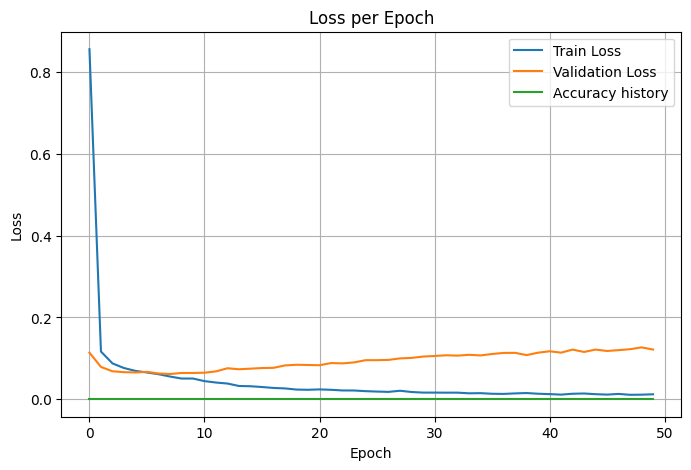

Bit by Bit accuracy

Query:              a91300000006000100000002
True Response:      a9130000000400010103
Predicted Response: a9130000000400010103

Query:              9d4400000006000300000002
True Response:      9d44000000070003040000caeb
Predicted Response: 9d4400000007000304ffffffff

Query:              f4e7000000060001fffc0002
True Response:      f4e700000003008102
Predicted Response: f4e700000003008102

Query:              5d88000000060003fffc0002
True Response:      5d8800000003008302
Predicted Response: 5d8800000003008302

Query:              67ca000000060005fffdff00
True Response:      67ca00000003008502
Predicted Response: 67ca00000003008502

✅ Byte-Level Accuracy: 96.77%
Exact Matching

Query:              a91300000006000100000002
True Response:      a9130000000400010103
Predicted Response: a9130000000400010103

Query:              9d4400000006000300000002
True Response:      9d44000000070003040000caeb
Predicted Response: 9d4400000007000304ffffffff

Query:              f4e70

In [ ]:
#Train with Validation dataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
hparams = best_hyper()
model = DecoderOnlyTransformer(VOCAB_SIZE, hparams["d_model"], hparams["n_heads"], hparams["n_layers"])

train_loader = DataLoader(train_dataset, batch_size=hparams["batch_size"], shuffle=True, collate_fn=collate)
val_loader = DataLoader(val_dataset, batch_size=hparams["batch_size"], shuffle=False, collate_fn=collate)

train_loss, val_loss, accuracy = train_transformer_change(model, train_loader, val_loader, hparams, device, max_gen_len=64)

plt.figure(figsize=(8,5))
plt.plot(train_loss, label="Train Loss")
plt.plot(val_loss, label="Validation Loss")
plt.plot(accuracy, label="Accuracy history" )
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.legend()
plt.grid(True)
plt.show()

print ("Bit by Bit accuracy")
evaluate(model, test_dataset, device)
print ("Exact Matching")
evaluate_exact(model, test_dataset, device)
print ("Validator Accuracy")
results = evaluate_with_validator(
    model=model,
    dataset=test_dataset,
    device=device,
    print_limit=3,
    end_address=39,
    save_errors=True,
    error_log_file="validator_failures_vocab260.csv"
)






In [11]:
evaluate_loss(model, test_dataset, device, loss_fn=None)


📉 Test Loss: 0.1001 over 14306 response tokens


0.10013128499518337

In [12]:
# #Train with Validation dataset
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# hparams = best_hyper()
# model = DecoderOnlyTransformer(VOCAB_SIZE, hparams["d_model"], hparams["n_heads"], hparams["n_layers"])

# train_loader = DataLoader(train_dataset, batch_size=hparams["batch_size"], shuffle=True, collate_fn=collate)
# val_loader = DataLoader(val_dataset, batch_size=hparams["batch_size"], shuffle=False, collate_fn=collate)

# train_loss, val_loss = train_transformer_val(model, train_loader, val_loader, hparams, device)

# plt.figure(figsize=(8,5))
# plt.plot(train_loss, label="Train Loss")
# plt.plot(val_loss, label="Validation Loss")
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.title("Loss per Epoch")
# plt.legend()
# plt.grid(True)
# plt.show()

# print ("Bit by Bit accuracy")
# evaluate(model, test_dataset, device)
# print ("Exact Matching")
# evaluate_exact(model, test_dataset, device)
# print ("Validator Accuracy")
# results = evaluate_with_validator(
#     model=model,
#     dataset=test_dataset,
#     device=device,
#     print_limit=3,
#     end_address=39,
#     save_errors=True,
#     error_log_file="validator_failures_vocab260.csv"
# )




In [13]:
# results = evaluate_with_validator(
#     model=model,
#     dataset=val_dataset,
#     device=device,
#     print_limit=3,
#     end_address=39,
#     save_errors=True,
#     error_log_file="validator_failures_vocab260.csv"
# )


Validation Accuracy: 0.0000
Epoch 1 | Train Loss: 0.5207 | Val Loss: 0.0846
Validation Accuracy: 0.0000
Epoch 2 | Train Loss: 0.0962 | Val Loss: 0.0973
Validation Accuracy: 0.0000
Epoch 3 | Train Loss: 0.0767 | Val Loss: 0.0764
Validation Accuracy: 0.0000
Epoch 4 | Train Loss: 0.0735 | Val Loss: 0.0749
Validation Accuracy: 0.0000
Epoch 5 | Train Loss: 0.0715 | Val Loss: 0.0650
Validation Accuracy: 0.0000
Epoch 6 | Train Loss: 0.0726 | Val Loss: 0.0681
Validation Accuracy: 0.0000
Epoch 7 | Train Loss: 0.0636 | Val Loss: 0.0689
Validation Accuracy: 0.0000
Epoch 8 | Train Loss: 0.0601 | Val Loss: 0.0669
Validation Accuracy: 0.0000
Epoch 9 | Train Loss: 0.0566 | Val Loss: 0.0725
Validation Accuracy: 0.0000
Epoch 10 | Train Loss: 0.0563 | Val Loss: 0.0684


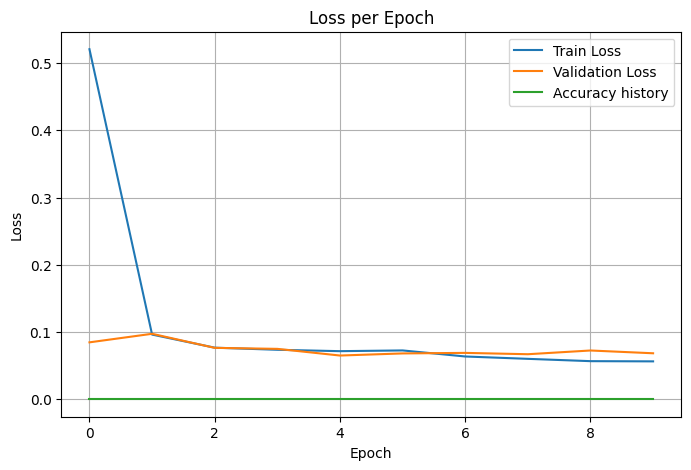

Bit by Bit accuracy

Query:              a91300000006000100000002
True Response:      a9130000000400010103
Predicted Response: a9130000000400010102

Query:              9d4400000006000300000002
True Response:      9d44000000070003040000caeb
Predicted Response: 9d4400000007000304ab6eab6e

Query:              f4e7000000060001fffc0002
True Response:      f4e700000003008102
Predicted Response: f4e700000003008102

Query:              5d88000000060003fffc0002
True Response:      5d8800000003008302
Predicted Response: 5d8800000003008302

Query:              67ca000000060005fffdff00
True Response:      67ca00000003008502
Predicted Response: 67ca00000003008502

✅ Byte-Level Accuracy: 96.67%
Exact Matching

Query:              a91300000006000100000002
True Response:      a9130000000400010103
Predicted Response: a9130000000400010102

Query:              9d4400000006000300000002
True Response:      9d44000000070003040000caeb
Predicted Response: 9d4400000007000304ab6eab6e

Query:              f4e70

In [15]:
#Train with Validation dataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
hparams = try_million_parameters()
model = DecoderOnlyTransformer(VOCAB_SIZE, hparams["d_model"], hparams["n_heads"], hparams["n_layers"])

train_loader = DataLoader(train_dataset, batch_size=hparams["batch_size"], shuffle=True, collate_fn=collate)
val_loader = DataLoader(val_dataset, batch_size=hparams["batch_size"], shuffle=False, collate_fn=collate)

train_loss, val_loss, accuracy = train_transformer_change(model, train_loader, val_loader, hparams, device, max_gen_len=64)


plt.figure(figsize=(8,5))
plt.plot(train_loss, label="Train Loss")
plt.plot(val_loss, label="Validation Loss")
plt.plot(accuracy, label="Accuracy history" )
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.legend()
plt.grid(True)
plt.show()

print ("Bit by Bit accuracy")
evaluate(model, test_dataset, device)
print ("Exact Matching")
evaluate_exact(model, test_dataset, device)
print ("Validator Accuracy")
results = evaluate_with_validator(
    model=model,
    dataset=test_dataset,
    device=device,
    print_limit=3,
    end_address=39,
    save_errors=True,
    error_log_file="validator_failures_vocab260.csv"
)




In [16]:
evaluate_loss(model, test_dataset, device, loss_fn=None)


📉 Test Loss: 0.0580 over 14306 response tokens


0.057988236848703766

In [ ]:
# model.eval()
#         total_tokens = 0
#         correct_tokens = 0
#         total_val_loss = 0

#         with torch.no_grad():
#             for batch in val_dataloader:
#                 x_full = batch["input_ids"].to(device)        # includes query + SEP (+ response)
#                 y_true = batch["labels"].to(device)            # masked: -100 before respons  
#                 logits = model(x)[:, :-1, :]
#                 targets = y[:, 1:]

#                 loss = loss_fn(logits.reshape(-1, VOCAB_SIZE), targets.reshape(-1))
#                 total_val_loss += loss.item()

#         avg_val_loss = total_val_loss / len(val_dataloader)
#         val_loss_history.append(avg_val_loss)

In [21]:
results = evaluate_with_validator(
    model=model,
    dataset=test_dataset,
    device=device,
    print_limit=3,
    end_address=39,
    save_errors=True,
    error_log_file="validator_failures_vocab260.csv"
)


Query:              a91300000006000100000002
True Response:      a9130000000400010103
Predicted Response: a9130000000400010103

Query:              9d4400000006000300000002
True Response:      9d44000000070003040000caeb
Predicted Response: 9d4400000007000304ffff8a44

Query:              f4e7000000060001fffc0002
True Response:      f4e700000003008102
Predicted Response: f4e700000003008102


📄 Saved all predictions to all_predictions.csv

✅ Exact Match Accuracy: 85.05%
🛡️  Validator Pass Rate: 99.61%
📝 Saved 5 failed validations to validator_failures_vocab260.csv


In [23]:
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"🔢 Total Trainable Parameters: {num_params:,}")

🔢 Total Trainable Parameters: 925,700


Epoch 1, Train Loss: 0.5466, Val Loss: 0.0880
Epoch 2, Train Loss: 0.0938, Val Loss: 0.0703
Epoch 3, Train Loss: 0.0769, Val Loss: 0.0675
Epoch 4, Train Loss: 0.0858, Val Loss: 0.0788
Epoch 5, Train Loss: 0.0756, Val Loss: 0.0723
Epoch 6, Train Loss: 0.0602, Val Loss: 0.0623
Epoch 7, Train Loss: 0.0543, Val Loss: 0.0690
Epoch 8, Train Loss: 0.0665, Val Loss: 0.0737
Epoch 9, Train Loss: 0.0573, Val Loss: 0.0673
Epoch 10, Train Loss: 0.0481, Val Loss: 0.0765
Epoch 11, Train Loss: 0.0605, Val Loss: 0.0724
Epoch 12, Train Loss: 0.0475, Val Loss: 0.0747
Epoch 13, Train Loss: 0.0464, Val Loss: 0.0760
Epoch 14, Train Loss: 0.0433, Val Loss: 0.0795
Epoch 15, Train Loss: 0.0445, Val Loss: 0.0777
Epoch 16, Train Loss: 0.0408, Val Loss: 0.0779
Epoch 17, Train Loss: 0.0401, Val Loss: 0.0796
Epoch 18, Train Loss: 0.0427, Val Loss: 0.0841
Epoch 19, Train Loss: 0.0368, Val Loss: 0.0819
Epoch 20, Train Loss: 0.0397, Val Loss: 0.0872
Epoch 21, Train Loss: 0.0308, Val Loss: 0.0868
Epoch 22, Train Loss: 

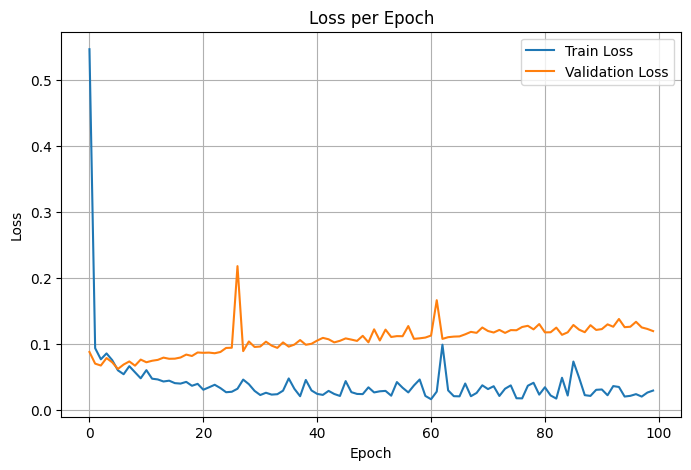

Bit by Bit accuracy

Query:              a91300000006000100000002
True Response:      a9130000000400010103
Predicted Response: a9130000000400010103

Query:              9d4400000006000300000002
True Response:      9d44000000070003040000caeb
Predicted Response: 9d4400000007000304ffffffff

Query:              f4e7000000060001fffc0002
True Response:      f4e700000003008102
Predicted Response: f4e700000003008102

Query:              5d88000000060003fffc0002
True Response:      5d8800000003008302
Predicted Response: 5d8800000003008302

Query:              67ca000000060005fffdff00
True Response:      67ca00000003008502
Predicted Response: 67ca00000003008502

✅ Byte-Level Accuracy: 96.40%
Exact Matching

Query:              a91300000006000100000002
True Response:      a9130000000400010103
Predicted Response: a9130000000400010103

Query:              9d4400000006000300000002
True Response:      9d44000000070003040000caeb
Predicted Response: 9d4400000007000304ffffffff

Query:              f4e70

In [ ]:
# #Try Model with much bigger size

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# hparams = try_million_parameters()
# model = DecoderOnlyTransformer(VOCAB_SIZE, hparams["d_model"], hparams["n_heads"], hparams["n_layers"])
# train_loader = DataLoader(train_dataset, batch_size=hparams["batch_size"], shuffle=True, collate_fn=collate)

# # loss_history= train_transformer(model, train_loader, hparams, device)
# train_loss, val_loss = train_transformer_val(model, train_loader, val_loader, hparams, device)

# plt.figure(figsize=(8,5))
# plt.plot(train_loss, label="Train Loss")
# plt.plot(val_loss, label="Validation Loss")
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.title("Loss per Epoch")
# plt.legend()
# plt.grid(True)
# plt.show()

# print ("Bit by Bit accuracy")
# evaluate(model, test_dataset, device)
# print ("Exact Matching")
# evaluate_exact(model, test_dataset, device)
# print ("Validator Accuracy")
# results = evaluate_with_validator(
#     model=model,
#     dataset=test_dataset,
#     device=device,
#     print_limit=3,
#     end_address=39,
#     save_errors=True,
#     error_log_file="validator_giant_model.csv"
# )

# #Counter of Parameters
# num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
# print(f"🔢 Total Trainable Parameters: {num_params:,}")





In [ ]:
# # Run BEST CONFIGURATION
#     #Best Combination found
# # d_model          128.000000
# # n_heads            4.000000
# # n_layers           4.000000
# # lr                 0.000500
# # batch_size        16.000000
# # epochs           500.000000
# # byte_accuracy     96.566265
# # Name: 39, dtype: float64

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# hparams = best_hyper()
# model = DecoderOnlyTransformer(VOCAB_SIZE, hparams["d_model"], hparams["n_heads"], hparams["n_layers"])
# train_loader = DataLoader(train_dataset, batch_size=hparams["batch_size"], shuffle=True, collate_fn=collate)

# # loss_history= train_transformer(model, train_loader, hparams, device)
# train_loss, val_loss = train_transformer_val(model, train_loader, val_loader, hparams, device)

# plt.figure(figsize=(8,5))
# plt.plot(train_loss, label="Train Loss")
# plt.plot(val_loss, label="Validation Loss")
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.title("Loss per Epoch")
# plt.legend()
# plt.grid(True)
# plt.show()

# print ("Bit by Bit accuracy")
# evaluate(model, test_dataset, device)
# print ("Exact Matching")
# evaluate_exact(model, test_dataset, device)
# print ("Validator Accuracy")



In [17]:
# results = evaluate_with_validator(
#     model=model,
#     dataset=test_dataset,
#     device=device,
#     print_limit=3,
#     end_address=39,
#     save_errors=True,
#     error_log_file="validator_failures_vocab260.csv"
# )


In [ ]:
#Number of Trainable Parameters Estimation 
# Params ≈ Embeddings + PosEmbed + (n_layers × LayerParams) + FinalLayer
#Layer Parameter:
# Multi-head attention (Q, K, V, out): 4 × d_model × d_model
# LayerNorms: 2 × d_model
# Feedforward (FFN): usually d_model × 4 × d_model → 2 × d_model × d_ff

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
hparams = best_hyper()
model = DecoderOnlyTransformer(VOCAB_SIZE, hparams["d_model"], hparams["n_heads"], hparams["n_layers"])
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total Trainable Parameters: {num_params:,}")

Total Trainable Parameters: 925,700


In [ ]:
def best_hyper():
    return {
        "d_model": 128,
        "n_heads": 4,
        "n_layers": 4,
        "lr": 5e-4,
        "batch_size": 16,
        "epochs": 50,
        "early_stop_patience": 10
    }

In [15]:
# Model
class DecoderOnlyTransformer(nn.Module):
    # vocab_size = how many distinct tokens we can embed
    #d_model =  size of each embedding vector.
    #n_heads: number of attention heads. Helps the model focus on different parts of the sequence simultaneously.
    # n_layers: number of transformer layers stacked
    def __init__(self, vocab_size, d_model, n_heads, n_layers, dropout=0.1):
        super().__init__()
        #Converts each token ID into a dense vector of dimension d_model.
        self.token_emb = nn.Embedding(vocab_size, d_model, padding_idx=PAD)
        self.pos_emb = nn.Embedding(512, d_model)
        # Even though we call it "encoder layer", apply causal masks later to make it autoregressive like a decoder.
        self.layers = nn.ModuleList([
            nn.TransformerEncoderLayer(
                d_model=d_model, nhead=n_heads, dim_feedforward=d_model*4, dropout=dropout, batch_first=True
            ) for _ in range(n_layers)
        ]) # dim_feedforward = Size of the hidden layer inside the feed-forward network of the Transformer.
        self.norm = nn.LayerNorm(d_model)
        #Maps the output of the model (of shape [batch, seq_len, d_model]) to logits over the vocabulary.
        self.output = nn.Linear(d_model, vocab_size)
        self.init_weights()  # <--- call your initializer

    def init_weights(self):
        # Token & Positional Embeddings: small normal noise
        nn.init.normal_(self.token_emb.weight, mean=0.0, std=0.02)
        nn.init.normal_(self.pos_emb.weight, mean=0.0, std=0.02)

        # Output layer: Xavier for balanced activations
        nn.init.xavier_uniform_(self.output.weight)
        nn.init.constant_(self.output.bias, 0)

        # Initialize Transformer Encoder Layers
        for layer in self.layers:
            for name, param in layer.named_parameters():
                if param.dim() > 1:  # weights
                    if "linear" in name or "weight" in name:
                        nn.init.xavier_uniform_(param)
                elif "bias" in name:
                    nn.init.constant_(param, 0)


    def forward(self, x):
        B, T = x.size() # B is the batch size, T is the sequence length (number of tokens in each input)
        positions = torch.arange(0, T, device=x.device).unsqueeze(0).expand(B, T)
        x = self.token_emb(x) + self.pos_emb(positions)
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(T).to(x.device) # Ensures the model can only attend to current and past tokens, not future ones
        for layer in self.layers:
            x = layer(x, src_mask=tgt_mask)  # Applies each encoder layer sequentially
        x = self.norm(x)
        return self.output(x) # Projects the final hidden states back to vocabulary space: for each token position, the model predicts a probability distribution over the 260 tokens (0–259)



In [19]:
#Experiment No Conversion Hexadecimal Bytes to Decima

# Constants
BOS, SEP, EOS, PAD = 16, 17, 18, 19
VOCAB_SIZE = 20  # 16 hex chars + 4 special tokens

# Load and preprocess dataset
# def preprocess_hex_chars(example):
#     # Keep query and response as hexadecimal characters
#     q = list(example["query"])    # e.g. "0103020001" → ['0','1','0','3',...]
#     r = list(example["response"])
#     # Convert hex chars to token ids (e.g. '0'→0, 'f'→15 or 'f'→255 depending on vocab)
#     char_to_id = {c: i for i, c in enumerate("0123456789abcdef")}
#     q_ids = [char_to_id[c.lower()] for c in q]
#     r_ids = [char_to_id[c.lower()] for c in r]

#     return {
#         "input_ids": [BOS] + q_ids + [SEP] + r_ids + [EOS]
#     }

def preprocess_hex_chars(example):
    char_to_id = {c: i for i, c in enumerate("0123456789abcdef")}
    q = [char_to_id[c.lower()] for c in example["query"]]
    r = [char_to_id[c.lower()] for c in example["response"]]
    input_ids = [BOS] + q + [SEP] + r + [EOS]
    # Create labels: PAD for query + SEP, actual IDs for response + EOS
    labels = [PAD] * (len(q) + 2) + r + [EOS]  # PAD for BOS + query + SEP
    return {
        "input_ids": input_ids,
        "labels": labels
    }

with open("modbus_dataset.jsonl", "r") as f:
    train_data = [json.loads(line) for line in f]

with open("modbus_dataset_test.jsonl", "r") as f:
    test_data = [json.loads(line) for line in f]

with open("modbus_dataset_validation.jsonl", "r") as f:
    validation_data = [json.loads(line) for line in f]

#turns a list of dictionaries into a Dataset object
train_dataset = Dataset.from_list([preprocess_hex_chars(d) for d in train_data])
test_dataset = Dataset.from_list([preprocess_hex_chars(d) for d in test_data])
val_dataset = Dataset.from_list([preprocess_hex_chars(d) for d in validation_data])

🔧 Current learning rate: 0.0005
Validation Accuracy: 0.0000
Epoch 1 | Train Loss: 0.2318 | Val Loss: 0.0303
🔧 Current learning rate: 0.0005
Validation Accuracy: 0.0000
Epoch 2 | Train Loss: 0.0363 | Val Loss: 0.0255
🔧 Current learning rate: 0.0005
Validation Accuracy: 0.0000
Epoch 3 | Train Loss: 0.0316 | Val Loss: 0.0236
🔧 Current learning rate: 0.0005
Validation Accuracy: 0.0000
Epoch 4 | Train Loss: 0.0281 | Val Loss: 0.0209
🔧 Current learning rate: 0.0005
Validation Accuracy: 0.0000
Epoch 5 | Train Loss: 0.0261 | Val Loss: 0.0207
🔧 Current learning rate: 0.0005
Validation Accuracy: 0.0000
Epoch 6 | Train Loss: 0.0258 | Val Loss: 0.0200
🔧 Current learning rate: 0.0005
Validation Accuracy: 0.0000
Epoch 7 | Train Loss: 0.0244 | Val Loss: 0.0197
🕒 No improvement for 1 epoch(s)
🔧 Current learning rate: 0.0005
Validation Accuracy: 0.0000
Epoch 8 | Train Loss: 0.0230 | Val Loss: 0.0211
🔧 Current learning rate: 0.0005
Validation Accuracy: 0.0000
Epoch 9 | Train Loss: 0.0237 | Val Loss: 0.0

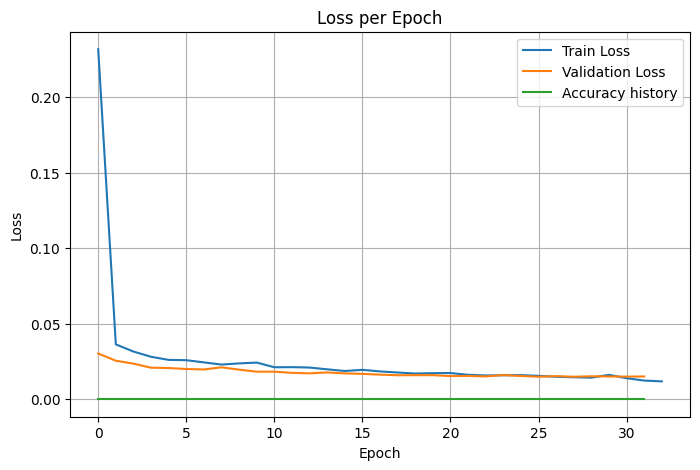

Bit by Bit accuracy

Query:              0a0901030000000000000006000000010000000000000002
True Response:      0a09010300000000000000040000000100010003
Predicted Response: 0a09010300000000000000040000000100010002

Query:              090d04040000000000000006000000030000000000000002
True Response:      090d04040000000000000007000000030004000000000c0a0e0b
Predicted Response: 090d040400000000000000070000000300040f0f0f0f0f0f0f0f

Query:              0f040e070000000000000006000000010f0f0f0c00000002
True Response:      0f040e070000000000000003000008010002
Predicted Response: 0f040e070000000000000003000008010002

Query:              050d08080000000000000006000000030f0f0f0c00000002
True Response:      050d08080000000000000003000008030002
Predicted Response: 050d08080000000000000003000008030002

Query:              06070c0a0000000000000006000000050f0f0f0d0f0f0000
True Response:      06070c0a0000000000000003000008050002
Predicted Response: 06070c0a0000000000000003000008050002

✅ Byte-Level Accura

In [20]:
# Train
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
hparams = best_hyper()
model = DecoderOnlyTransformer(VOCAB_SIZE, hparams["d_model"], hparams["n_heads"], hparams["n_layers"])
train_loader = DataLoader(train_dataset, batch_size=hparams["batch_size"], shuffle=True, collate_fn=collate)
val_loader = DataLoader(val_dataset, batch_size=hparams["batch_size"], shuffle=False, collate_fn=collate)

train_loss, val_loss, accuracy = train_transformer_change(model, train_loader, val_loader, hparams, device, max_gen_len=64)

plt.figure(figsize=(8,5))
plt.plot(train_loss, label="Train Loss")
plt.plot(val_loss, label="Validation Loss")
plt.plot(accuracy, label="Accuracy history" )
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.legend()
plt.grid(True)
plt.show()

print ("Bit by Bit accuracy")
evaluate(model, test_dataset, device)
print ("Exact Matching")
evaluate_exact(model, test_dataset, device)
print ("Validator Accuracy")
results = evaluate_with_validator(
    model=model,
    dataset=test_dataset,
    device=device,
    print_limit=3,
    end_address=39,
    save_errors=True,
    error_log_file="validator_failures_vocab260.csv"
)

#Counter of Parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"🔢 Total Trainable Parameters: {num_params:,}")





🔧 Current learning rate: 0.0005
Validation Accuracy: 0.0000
Epoch 1 | Train Loss: 0.4115 | Val Loss: 0.0386
🔧 Current learning rate: 0.0005
Validation Accuracy: 0.0000
Epoch 2 | Train Loss: 0.0393 | Val Loss: 0.0252
🔧 Current learning rate: 0.0005
Validation Accuracy: 0.0000
Epoch 3 | Train Loss: 0.0311 | Val Loss: 0.0236
🔧 Current learning rate: 0.0005
Validation Accuracy: 0.0000
Epoch 4 | Train Loss: 0.0485 | Val Loss: 0.0228
🕒 No improvement for 1 epoch(s)
🔧 Current learning rate: 0.0005
Validation Accuracy: 0.0000
Epoch 5 | Train Loss: 0.0292 | Val Loss: 0.0237
🔧 Current learning rate: 0.0005
Validation Accuracy: 0.0000
Epoch 6 | Train Loss: 0.0290 | Val Loss: 0.0225
🕒 No improvement for 1 epoch(s)
🔧 Current learning rate: 0.0005
Validation Accuracy: 0.0000
Epoch 7 | Train Loss: 0.0335 | Val Loss: 0.0230
🕒 No improvement for 2 epoch(s)
🔧 Current learning rate: 0.0005
Validation Accuracy: 0.0000
Epoch 8 | Train Loss: 0.0298 | Val Loss: 0.0295
🕒 No improvement for 3 epoch(s)
🔧 Curren

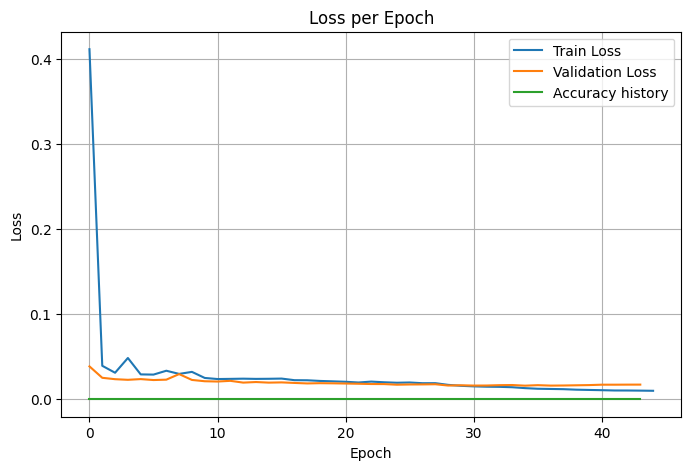

Bit by Bit accuracy

Query:              0a0901030000000000000006000000010000000000000002
True Response:      0a09010300000000000000040000000100010003
Predicted Response: 0a09010300000000000000040000000100010001

Query:              090d04040000000000000006000000030000000000000002
True Response:      090d04040000000000000007000000030004000000000c0a0e0b
Predicted Response: 090d040400000000000000070000000300040f0f0f0f0f0f0f0f

Query:              0f040e070000000000000006000000010f0f0f0c00000002
True Response:      0f040e070000000000000003000008010002
Predicted Response: 0f040e070000000000000003000008010002

Query:              050d08080000000000000006000000030f0f0f0c00000002
True Response:      050d08080000000000000003000008030002
Predicted Response: 050d08080000000000000003000008030002

Query:              06070c0a0000000000000006000000050f0f0f0d0f0f0000
True Response:      06070c0a0000000000000003000008050002
Predicted Response: 06070c0a0000000000000003000008050002

✅ Byte-Level Accura

In [30]:
# Train
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
hparams = try_million_parameters()
model = DecoderOnlyTransformer(VOCAB_SIZE, hparams["d_model"], hparams["n_heads"], hparams["n_layers"])
train_loader = DataLoader(train_dataset, batch_size=hparams["batch_size"], shuffle=True, collate_fn=collate)
val_loader = DataLoader(val_dataset, batch_size=hparams["batch_size"], shuffle=False, collate_fn=collate)

train_loss, val_loss, accuracy = train_transformer_change(model, train_loader, val_loader, hparams, device, max_gen_len=64)

plt.figure(figsize=(8,5))
plt.plot(train_loss, label="Train Loss")
plt.plot(val_loss, label="Validation Loss")
plt.plot(accuracy, label="Accuracy history" )
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.legend()
plt.grid(True)
plt.show()

print ("Bit by Bit accuracy")
evaluate(model, test_dataset, device)
print ("Exact Matching")
evaluate_exact(model, test_dataset, device)
print ("Validator Accuracy")
results = evaluate_with_validator(
    model=model,
    dataset=test_dataset,
    device=device,
    print_limit=3,
    end_address=39,
    save_errors=True,
    error_log_file="validator_failures_vocab260.csv"
)

#Counter of Parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"🔢 Total Trainable Parameters: {num_params:,}")





In [21]:
evaluate_loss(model, test_dataset, device)

✅ Test Loss (no leakage): 0.0345


0.03446968835892995

In [ ]:
# Train
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
hparams = best_hyper()
model = DecoderOnlyTransformer(VOCAB_SIZE, hparams["d_model"], hparams["n_heads"], hparams["n_layers"])
train_loader = DataLoader(train_dataset, batch_size=hparams["batch_size"], shuffle=True, collate_fn=collate)
val_loader = DataLoader(val_dataset, batch_size=hparams["batch_size"], shuffle=False, collate_fn=collate)

train_loss, val_loss, accuracy = train_transformer_change(model, train_loader, val_loader, hparams, device, max_gen_len=64)

plt.figure(figsize=(8,5))
plt.plot(train_loss, label="Train Loss")
plt.plot(val_loss, label="Validation Loss")
plt.plot(accuracy, label="Accuracy history" )
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.legend()
plt.grid(True)
plt.show()

print ("Bit by Bit accuracy")
evaluate(model, test_dataset, device)
print ("Exact Matching")
evaluate_exact(model, test_dataset, device)
print ("Validator Accuracy")
results = evaluate_with_validator(
    model=model,
    dataset=test_dataset,
    device=device,
    print_limit=3,
    end_address=39,
    save_errors=True,
    error_log_file="validator_failures_vocab260.csv"
)

#Counter of Parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"🔢 Total Trainable Parameters: {num_params:,}")





🔧 Current learning rate: 0.0005
Validation Accuracy: 0.0000
Epoch 1 | Train Loss: 0.2289 | Val Loss: 0.0323
🔧 Current learning rate: 0.0005
Validation Accuracy: 0.0000
Epoch 2 | Train Loss: 0.0386 | Val Loss: 0.0254
🔧 Current learning rate: 0.0005
Validation Accuracy: 0.0000
Epoch 3 | Train Loss: 0.0316 | Val Loss: 0.0231
🔧 Current learning rate: 0.0005
Validation Accuracy: 0.0000
Epoch 4 | Train Loss: 0.0285 | Val Loss: 0.0219
🔧 Current learning rate: 0.0005
Validation Accuracy: 0.0000
Epoch 5 | Train Loss: 0.0303 | Val Loss: 0.0222
🔧 Current learning rate: 0.0005
Validation Accuracy: 0.0000
Epoch 6 | Train Loss: 0.0261 | Val Loss: 0.0202
🔧 Current learning rate: 0.0005
Validation Accuracy: 0.0000
Epoch 7 | Train Loss: 0.0243 | Val Loss: 0.0197
🔧 Current learning rate: 0.0005
Validation Accuracy: 0.0000
Epoch 8 | Train Loss: 0.0241 | Val Loss: 0.0198
🔧 Current learning rate: 0.0005
Validation Accuracy: 0.0000
Epoch 9 | Train Loss: 0.0236 | Val Loss: 0.0193
🔧 Current learning rate: 0.0

In [24]:
# #Train with Validation dataset
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# hparams = best_hyper()
# model = DecoderOnlyTransformer(VOCAB_SIZE, hparams["d_model"], hparams["n_heads"], hparams["n_layers"])


# train_loader = DataLoader(train_dataset, batch_size=hparams["batch_size"], shuffle=True, collate_fn=collate)
# val_loader = DataLoader(val_dataset, batch_size=hparams["batch_size"], shuffle=False, collate_fn=collate)
# train_loss, val_loss = train_transformer_val(model, train_loader, val_loader, hparams, device)


# plt.figure(figsize=(8,5))
# plt.plot(train_loss, label="Train Loss")
# plt.plot(val_loss, label="Validation Loss")
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.title("Loss per Epoch")
# plt.legend()
# plt.grid(True)
# plt.show()

# print ("Bit by Bit accuracy")
# evaluate(model, test_dataset, device)
# print ("Exact Matching")
# evaluate_exact(model, test_dataset, device)
# print ("Validator Accuracy")

# results = evaluate_with_validator(
#     model=model,
#     dataset=test_dataset,
#     device=device,
#     print_limit=3,
#     end_address=3,
#     save_errors=True,
#     error_log_file="validator_failures_vocab260.csv"
# )



In [ ]:

#Searching for best configuration for experiment of no translation preprocessing

configs = [
    {"d_model": 128, "n_heads": 4, "n_layers": 4, "lr": 0.0005, "batch_size": 16, "epochs": 500},
    {"d_model": 128, "n_heads": 2, "n_layers": 4, "lr": 0.0001, "batch_size": 16, "epochs": 250},
    {"d_model": 128, "n_heads": 4, "n_layers": 8, "lr": 0.0005, "batch_size": 16, "epochs": 100},
    {"d_model": 128, "n_heads": 8, "n_layers": 2, "lr": 0.0005, "batch_size": 16, "epochs": 50},
    {"d_model": 256, "n_heads": 8, "n_layers": 4, "lr": 0.0005, "batch_size": 16, "epochs": 50},
    {"d_model": 256, "n_heads": 8, "n_layers": 8, "lr": 0.0001, "batch_size": 16, "epochs": 250},
    {"d_model": 256, "n_heads": 8, "n_layers": 8, "lr": 0.0001, "batch_size": 16, "epochs": 500},
    {"d_model": 128, "n_heads": 16, "n_layers": 8, "lr": 0.0005, "batch_size": 16, "epochs": 50},
    {"d_model": 128, "n_heads": 16, "n_layers": 4, "lr": 0.0005, "batch_size": 16, "epochs": 50},
    {"d_model": 256, "n_heads": 8, "n_layers": 4, "lr": 0.0001, "batch_size": 16, "epochs": 50},
]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for idx, hparams in enumerate(configs):
    print(f"\n🔁 Testing Model {idx+1} with config: {hparams}")

    model = DecoderOnlyTransformer(
        vocab_size=VOCAB_SIZE,
        d_model=hparams["d_model"],
        n_heads=hparams["n_heads"],
        n_layers=hparams["n_layers"],
    ).to(device)

    train_loader = DataLoader(train_dataset, batch_size=hparams["batch_size"], shuffle=True, collate_fn=collate)

    # Optional: Skip training if you've already trained these models
    train_transformer(model, train_loader, hparams, device)

    # Evaluation
    print("🎯 Byte-Level Accuracy:")
    evaluate(model, test_dataset, device)

    print("✅ Exact Match Accuracy:")
    evaluate_exact(model, test_dataset, device)

    print("Validator accuracy")
    results = evaluate_with_validator(
    model=model,
    dataset=test_dataset,
    device=device,
    print_limit=5,              # Optional
    end_address=255,            # Adjust based on your data
    save_errors=True,
    error_log_file="validator_failures_loop.csv"
     )



In [33]:
# #Grid search

# import itertools
# import pandas as pd
# from torch.utils.data import DataLoader
# import torch
# import torch.nn as nn

# # Define the grid of values
# param_grid = {
#     "d_model": [128, 256],
#     "n_heads": [2, 4, 8, 16],
#     "n_layers": [2, 4, 8],
#     "lr": [1e-4, 5e-4],
#     "batch_size": [16],    # fixed
#     "epochs": [50,100, 250, 500]        # fixed
# }

# #Best Combination found
# # d_model          128.000000
# # n_heads            4.000000
# # n_layers           4.000000
# # lr                 0.000500
# # batch_size        16.000000
# # epochs           500.000000
# # byte_accuracy     96.566265
# # Name: 39, dtype: float64

# # Create all combinations of hyperparameters
# grid = list(itertools.product(
#     param_grid["d_model"],
#     param_grid["n_heads"],
#     param_grid["n_layers"],
#     param_grid["lr"],
#     param_grid["batch_size"],
#     param_grid["epochs"]
# ))
# # 
# # Convert to DataFrame for easier access
# grid_df = pd.DataFrame(grid, columns=["d_model", "n_heads", "n_layers", "lr", "batch_size", "epochs"])

# results = []
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# for idx, trial in grid_df.iterrows():
#     print(f"\n🔁 Trial {idx+1}/{len(grid_df)} - Config: {trial.to_dict()}")

#     # Build model
#     model = DecoderOnlyTransformer(
#         vocab_size=VOCAB_SIZE,
#         d_model=int(trial["d_model"]),
#         n_heads=int(trial["n_heads"]),
#         n_layers=int(trial["n_layers"]),
#         dropout=0.1
#     ).to(device)

#     # Prepare DataLoader
#     loader = DataLoader(train_dataset, batch_size=int(trial["batch_size"]), shuffle=True, collate_fn=collate)

#     # Training
#     hparams = {
#         "lr": trial["lr"],
#         "epochs": int(trial["epochs"])
#     }

#     loss_history= train_transformer(model, loader, hparams, device)

#         # Plotting
#     plt.figure(figsize=(8,5))
#     plt.plot(range(1, len(loss_history)+1), loss_history, marker='o')
#     plt.title(f"Training Loss per Epoch. Trial: #{idx+1}")
#     plt.xlabel("Epoch")
#     plt.ylabel("Loss")
#     plt.grid(True)
#     plt.show()


#     # Evaluation
#     acc = evaluate(model, test_dataset, device)
#     print(f"🧠 Byte-level Accuracy: {acc:.2f}%")

#     # Save results
#     results.append({
#         **trial.to_dict(),
#         "byte_accuracy": acc
#     })

# # Optionally convert to DataFrame for analysis
# import pandas as pd
# results_df = pd.DataFrame(results)
# results_df.to_csv("grid_search_results.csv", index=False)
# print("\n✅ Grid search complete. Results saved to grid_search_results.csv.")



In [ ]:
best_trial = results_df.sort_values(by="byte_accuracy", ascending=False).iloc[0]
print("🏆 Best Hyperparameter Configuration:")
print(best_trial)

In [11]:
import csv
import pandas as pd

# Open the CSV file in read mode ('r') with newline=''
# The newline='' argument is crucial to prevent extra blank rows
# when reading on some operating systems.

df = pd.read_csv('grid_search_results.csv')

best_trial = df.sort_values(by="byte_accuracy", ascending=False).iloc[0:10]
print("🏆 Best Hyperparameter Configuration:")
print(best_trial)

🏆 Best Hyperparameter Configuration:
     d_model  n_heads  n_layers      lr  batch_size  epochs  byte_accuracy
39     128.0      4.0       4.0  0.0005        16.0   500.0      96.566265
10     128.0      2.0       4.0  0.0001        16.0   250.0      96.445783
45     128.0      4.0       8.0  0.0005        16.0   100.0      96.445783
52     128.0      8.0       2.0  0.0005        16.0    50.0      96.445783
156    256.0      8.0       4.0  0.0005        16.0    50.0      96.445783
162    256.0      8.0       8.0  0.0001        16.0   250.0      96.385542
163    256.0      8.0       8.0  0.0001        16.0   500.0      96.325301
92     128.0     16.0       8.0  0.0005        16.0    50.0      96.325301
84     128.0     16.0       4.0  0.0005        16.0    50.0      96.265060
152    256.0      8.0       4.0  0.0001        16.0    50.0      96.265060


In [ ]:
#Best Combination found
# d_model          128.000000
# n_heads            4.000000
# n_layers           4.000000
# lr                 0.000500
# batch_size        16.000000
# epochs           500.000000
# byte_accuracy     96.566265
# Name: 39, dtype: float64